<a href="https://colab.research.google.com/github/R-802/LING-226-Assignments/blob/main/Assignment_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Shemaiah Rangitaawa Assignment One LING226 2023 T3 `300601546`**
- Attempting Challenge

### **Text Preprocessing `preprocess_text`**
**Remove Punctuation**
- The function strips all punctuation from the text.

**Remove Stopwords**
- Stopwords, like "the", "is", "at" are removed from the text.

**Lowercase All Words**
- The text is converted to lowercase. This standardization is important as it prevents the same words in different cases from being counted as different words (e.g., "Hello" and "hello").

**Remove Words Above a Certain Frequency (Inclusive)**
- Words that appear very rarely or very frequently in the dataset can be removed. Rare words might be typos or irrelevant, and very common words might not carry useful information.


In [1]:
import re
from collections import Counter

def preprocess_text(text, stopwords, removal_frequency):
    # Lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text).lower()

    # Split text into words
    words = text.split()

    # Count the frequency of each word
    word_frequency = Counter(words)

    # Identify words to remove: stopwords and words exceeding the frequency threshold
    removed_words = set(stopwords).union(
        {word for word, freq in word_frequency.items() if freq >= removal_frequency}
    )

    # Filter out removed words
    processed_words = [word for word in words if word not in removed_words]

    return ' '.join(processed_words), list(removed_words)

### **Function to Reveal Removed Characters `print_removed`**

**Processes Original Text**
- Converts all characters to lowercase.
- Removes any characters that are not alphanumeric or whitespace.
- Splits the text into words.

**Process Preprocessed Text**
- Splits the preprocessed text into words.

**Compare Words**
- Uses word frequency counts to identify which words from the original text are not present in the preprocessed text.
- Generates a list of these removed words.

**Identify Removed Characters**
- Compares the character sets of the original and preprocessed texts.
- Lists characters present in the original text but not in the preprocessed text.

In [2]:
from typing import List, Tuple

def text_metrics(text: str) -> Tuple[int, float, float, int, List[Tuple[str, int]]]:
    # Tokenizing the text into words
    words = re.findall(r'\b\w+\b', text.lower())
    total_words = len(words)

    # Overall lexical diversity (unique words / total words)
    unique_words = len(set(words))
    overall_lexical_diversity = unique_words / total_words if total_words > 0 else 0

    # Tokenizing the text into sentences and calculating diversity
    sentences = re.split(r'[.!?]', text)
    num_sentences = len(sentences)  # Number of sentences in the text
    sentence_diversities = []
    for sentence in sentences:
        sentence_words = re.findall(r'\b\w+\b', sentence.lower())
        unique_in_sentence = len(set(sentence_words))
        total_in_sentence = len(sentence_words)
        if total_in_sentence > 0:
            sentence_diversities.append(unique_in_sentence / total_in_sentence)

    # Average lexical diversity of text sentences
    avg_sentence_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Top ten most frequent words
    word_frequencies = Counter(words)
    top_ten_words = word_frequencies.most_common(10)

    return total_words, overall_lexical_diversity, avg_sentence_diversity, num_sentences, top_ten_words

### **Text Metric Function `text_metrics`**
**Total Words**
- The total count of words in the text.

**Overall Lexical Diversity**
- The ratio of unique words to the total number of words, providing a measure of the text's vocabulary variety.

**Average Sentence Lexical Diversity**
- The average diversity of vocabulary used across all sentences in the text.

**Top Ten Most Frequent Word:**
- A list of the ten most commonly used words in the text, along with their frequencies.

In [3]:
def text_metrics(text):
    # Tokenizing the text into words
    words = re.findall(r'\b\w+\b', text.lower())
    total_words = len(words)

    # Overall lexical diversity (unique words / total words)
    unique_words = len(set(words))
    overall_lexical_diversity = unique_words / total_words if total_words > 0 else 0

    # Tokenizing the text into sentences and calculating diversity
    sentences = re.split(r'[.!?]', text)
    sentence_diversities = []
    for sentence in sentences:
        sentence_words = re.findall(r'\b\w+\b', sentence.lower())
        unique_in_sentence = len(set(sentence_words))
        total_in_sentence = len(sentence_words)
        if total_in_sentence > 0:
            sentence_diversities.append(unique_in_sentence / total_in_sentence)

    # Average lexical diversity of text sentences
    avg_sentence_lexical_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Top ten most frequent words
    word_frequencies = Counter(words)
    top_ten_words = word_frequencies.most_common(10)

    # Number of sentences
    num_sentences = len(sentences)

    return total_words, overall_lexical_diversity, avg_sentence_lexical_diversity, top_ten_words, num_sentences


###**Formatting for Text Metrics**

In [4]:
def format_metrics(title, metrics):
    formatted_top_words = ', '.join([word for word, _ in metrics[3]])
    highest_word, highest_freq = metrics[3][0]  # Extracting the highest frequency word and its frequency

    # Formatting the diversities as percentages
    overall_diversity_percentage = metrics[1] * 100
    avg_sentence_diversity_percentage = metrics[2] * 100

    return (f"--------- Text Metrics for {title} ---------\n"
            f"Total Words: {metrics[0]}\n"
            f"Total Sentences: {metrics[4]}\n"
            f"Overall Lexical Diversity: {overall_diversity_percentage:.2f}%\n"
            f"Average Lexical Diversity of Sentences: {avg_sentence_diversity_percentage:.2f}%\n"
            f"Top Ten Most Frequent Words: {formatted_top_words}\n"
            f"Highest Frequency Word: '{highest_word}' (Frequency: {highest_freq})")


## **Importing and Reading `TP001.txt` from URL and `austen-emma.txt` from NLTK corpora**

In [5]:
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt'

--2023-11-16 11:21:14--  https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220746 (216K) [text/plain]
Saving to: ‘tp001.txt’

tp001.txt           100%[===================>] 215.57K  --.-KB/s    in 0.04s   

2023-11-16 11:21:14 (5.56 MB/s) - ‘tp001.txt’ saved [220746/220746]



In [6]:
# Open the file and read its lines
with open('tp001.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Concatenate all comments into a single text string
tp001_text = ""
for line in lines:
    if '\t' in line:
        comment = line.split('\t')[1].strip()  # Extract and strip the comment
        tp001_text += comment + " "  # Add the comment to the text string

# Optionally, display the first part of the concatenated text
print("First part of tp001_text:", tp001_text[:500])

First part of tp001_text: ... we need to work hard to make it happen 3d is better than other bands in the whole country a ban on sales of new petrol vehicles would be more sensible than an outright ban .  an outright ban is itself wasteful A carless life is much more fun A good idea in theory but would have to change a lot of infrastructure. Not to mention industry and jobs. a good idea to protect our earth ! A good opportunity to reduce harm to the environment A N G E R Y A s part of many other changes A STEP IN THE RIG


In [7]:
import nltk
from nltk.corpus import gutenberg

# Download gutenberg corpus
nltk.download('gutenberg')

# Using Emma by Jane Austen 1816
emma_text = gutenberg.raw('austen-emma.txt')
print(emma_text[:290])

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.



# **Experimentation**
The following experimentation section includes:
- An analysis and overview of metrics from both sample texts.  
- Visualization of the top ten words before and after processing.
- Analysis of Emma's overall lexical diversity before and after processing.

**Notes:** I have chosen to use the NLTK's stopword list for preprocessing. I  have used 'Emma by Jane Austen 1816' from NLTK corpora and 'TP001 (Petrol cars should be banned by 2030)' from The Current.

### **Importing libraries and initializing stopwords set**
Required for preprocessing and visualization.

In [8]:
import random
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

# Tokenizer divides a text into a list of sentences
nltk.download('punkt')

# Download the stopwords from NLTK
nltk.download('stopwords')

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# For some reason 'n' was the top word in tp001
stop_words.add('n')

print(stop_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


{'again', 'its', 'didn', 'this', 'too', "hadn't", 'here', 'will', 'only', 'then', "you'd", 'most', "it's", 'not', 'both', 'hers', 'weren', 'ours', 'it', 'were', "weren't", "that'll", 's', 'did', 'should', 'down', 'more', 'on', 'how', 'does', "aren't", "needn't", "mightn't", 'do', 'myself', 'once', 'his', 'having', 'any', 'who', 'll', 'hadn', 'herself', 'no', "shan't", "you'll", 'him', 'out', 'an', 'by', "didn't", 'haven', 'mustn', "wasn't", 'm', 'a', 'ain', 'for', 'each', "won't", 'or', 'have', 'against', "you're", 'very', "mustn't", 'so', 'be', 'between', 'isn', 'we', 'all', "haven't", 'until', 'where', 'me', 'about', 'himself', 'off', 'itself', 'few', 'there', 'some', "shouldn't", 'o', 'had', 'and', 'those', 'with', 'over', 'to', 'y', 'as', 'don', 'my', "she's", 'has', 'because', 'through', 'doing', "you've", 'below', 'doesn', 'am', 'from', 'can', 'that', 're', 'whom', 'n', 'needn', "wouldn't", 'wasn', 'if', 'theirs', 'own', 'are', 'into', 'your', 'was', 'after', "should've", 'during

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Analysis and overview of metrics from both sample texts**

### Text Metrics for "Emma" by Jane Austen
#### Unprocessed Text

- **Total Words:** `161,983`
  - Indicates the substantial length typical of 19th-century novels.
- **Total Sentences:** `10,567`
- **Overall Lexical Diversity:** `4.48%`
  - A relatively small proportion of unique words, common in longer texts with repetitive usage of certain words.
- **Average Lexical Diversity of Sentences:** `94.43%`
  - Most sentences contain a high proportion of unique words, suggesting varied sentence structures and vocabulary.
- **Top Ten Most Frequent Words:** `to, the, and, of, i, a, it, her, was, she`
  - Common in unprocessed English texts, indicating frequent use of linguistic connectors and pronouns.
- **Highest Frequency Word:** `'to'` (Frequency: `5,239`)
  - Highlights its prevalent role in sentence construction.

#### Processed Text

- **Total Words:** `56,909`
  - Significantly lower, likely due to the removal of common words and other processing steps.
- **Total Sentences:** `1`
  - This is an artifact of how the processing method and specifically NLTK's Punkt sentence tokenizer processes text. As there is no punctuation for Punkt to rely on, it's not able to identify sentence boundaries.
- **Overall Lexical Diversity:** `16.32%`
  - Higher than the unprocessed text, suggesting a greater variety of unique words after removing common ones.
- **Average Lexical Diversity of Sentences:** `16.32%`
  - Identical to the overall diversity due to the text being treated as a single sentence post-processing.
- **Top Ten Most Frequent Words:** `frank, ever, young, churchill, two, though, indeed, better, come, oh`
  - More specific and thematic, focusing on characters and narrative elements.
- **Highest Frequency Word:** `'frank'` (Frequency: `192`)
  - Indicates a shift towards content-specific vocabulary.

#### Insights and Implications

- **Impact of Processing:**
  - The processing significantly alters the text's word count and frequency distribution, emphasizing content-specific words.
- **Narrative Focus:**
  - The shift in frequent words from common linguistic elements to character names and thematic words reflects the novel's narrative focus.
- **Lexical Diversity:**
  - The increase in lexical diversity in the processed text underscores the contribution of unique, content-specific words to the richness of vocabulary, as opposed to common structural words.

---

## Text Metrics Analysis for `tp001`

#### Unprocessed Text

- **Total Words:** `39,065`
- **Total Sentences:** `2,037`
- **Overall Lexical Diversity:** `12.06%`
  - Shows a reasonable variety of vocabulary for a document of this length.
- **Average Lexical Diversity of Sentences:** `89.43%`
  - Most sentences have a high proportion of unique words, indicating diverse sentence construction.
- **Top Ten Most Frequent Words:** `the, to, we, and, i, it, a, is, be, for`
  - Typical of unprocessed English texts, these are common structural words.
- **Highest Frequency Word:** `'the'` (Frequency: `1,507`)
  - Common in English texts, often used for grammatical structure.

#### Processed Text

- **Total Words:** `18,059`
  - Significantly reduced, likely due to the removal of common words and possibly other processing steps.
- **Total Sentences:** `1`
  - This suggests that the processing may have concatenated the text into a single block.
- **Overall Lexical Diversity:** `25.80%`
  - A noticeable increase from the unprocessed text, indicating a higher proportion of unique words after processing.
- **Average Lexical Diversity of Sentences:** `25.80%`
  - Identical to the overall diversity, due to the text being treated as a single sentence.
- **Top Ten Most Frequent Words:** `environment, future, would, people, bad, world, make, dont, transport, climate`
  - These words reveal the main focus of the text.
- **Highest Frequency Word:** `'environment'` (Frequency: `189`)
  - Indicates a strong emphasis on environmental themes in the text.

#### Insights and Implications

- **Impact of Processing:**
  - The reduction in total word count and the shift in word frequency distribution underscore the effect of text processing.
- **Thematic Focus:**
  - Processing the text highlights specific themes like the environment and future, which are less apparent in the unprocessed text due to the prevalence of common structural words.
- **Lexical Diversity:**
  - The increase in lexical diversity post-processing reflects the removal of common words, leaving a text rich in unique, content-specific vocabulary.

In [9]:
# Get text metrics for raw unprocessed text
emma_metrics = text_metrics(emma_text)
tp001_metrics = text_metrics(tp001_text)

# Extracting top ten words and their frequencies for plotting for both texts
emma_top_ten_words, emma_frequencies = zip(*emma_metrics[3])
tp001_top_ten_words, tp001_frequencies = zip(*tp001_metrics[3])

# Extract the number of sentences
emma_num_sentences = emma_metrics[4]
tp001_num_sentences = tp001_metrics[4]

# Generate a random text occurrence removal frequency
random_frequency = random.randint(125, 300)

# Preprocess the texts
preprocessed_emma, _ = preprocess_text(emma_text, stop_words, random_frequency)
preprocessed_tp001, _ = preprocess_text(tp001_text, stop_words, random_frequency)

# Get metrics for preprocessed texts
preprocessed_emma_metrics = text_metrics(preprocessed_emma)
preprocessed_tp001_metrics = text_metrics(preprocessed_tp001)

# Extracting top ten words and their frequencies for preprocessed texts
preprocessed_emma_top_ten, preprocessed_emma_freq = zip(*preprocessed_emma_metrics[3])
preprocessed_tp001_top_ten, preprocessed_tp001_freq = zip(*preprocessed_tp001_metrics[3])

# Extract the number of sentences for preprocessed texts
preprocessed_emma_num_sentences = preprocessed_emma_metrics[4]
preprocessed_tp001_num_sentences = preprocessed_tp001_metrics[4]

print(format_metrics("Emma (Unprocessed)", emma_metrics) + "\n")
print(format_metrics("tp001.txt (Unprocessed)", tp001_metrics) + "\n")
print(format_metrics("Emma (Processed)", preprocessed_emma_metrics) + "\n")
print(format_metrics("tp001.txt (Processed)", preprocessed_tp001_metrics) + "\n")
print(f"\nRemoved words that occurred more than {random_frequency} times.")

--------- Text Metrics for Emma (Unprocessed) ---------
Total Words: 161983
Total Sentences: 10567
Overall Lexical Diversity: 4.48%
Average Lexical Diversity of Sentences: 94.43%
Top Ten Most Frequent Words: to, the, and, of, i, a, it, her, was, she
Highest Frequency Word: 'to' (Frequency: 5239)

--------- Text Metrics for tp001.txt (Unprocessed) ---------
Total Words: 39065
Total Sentences: 2037
Overall Lexical Diversity: 12.06%
Average Lexical Diversity of Sentences: 89.43%
Top Ten Most Frequent Words: the, to, we, and, i, it, a, is, be, for
Highest Frequency Word: 'the' (Frequency: 1507)

--------- Text Metrics for Emma (Processed) ---------
Total Words: 56909
Total Sentences: 1
Overall Lexical Diversity: 16.32%
Average Lexical Diversity of Sentences: 16.32%
Top Ten Most Frequent Words: frank, ever, young, churchill, two, though, indeed, better, come, oh
Highest Frequency Word: 'frank' (Frequency: 192)

--------- Text Metrics for tp001.txt (Processed) ---------
Total Words: 18059
To

# **Visualization of The Top Ten Words with Their Frequencies Before and After Processing**
Visualizing the top ten words with their frequencies in a text offers key insights:

- **Theme Identification**: Frequent words in a text often reflect its central themes or subjects. For example, in `tp001`, words like "environment" and "future" are prevalent.
- **Comparative Analysis**: By contrasting the top words in processed and unprocessed texts, we can see how text processing changes the focus. Common words often dominate unprocessed texts, while processed texts highlight more specific, thematic vocabulary.
- **Stylistic Insights**: The frequency of certain words can reveal an author's style or the text's focus. In literary works, character names or key motifs might frequently appear, while technical texts might frequently use specific jargon.
- **Visualization Techniques**: Bar charts are commonly used for such visualizations, providing a clear comparison of word frequencies. Each bar represents a word, with its length indicating frequency. This straightforward representation allows for easy comparison and interpretation.

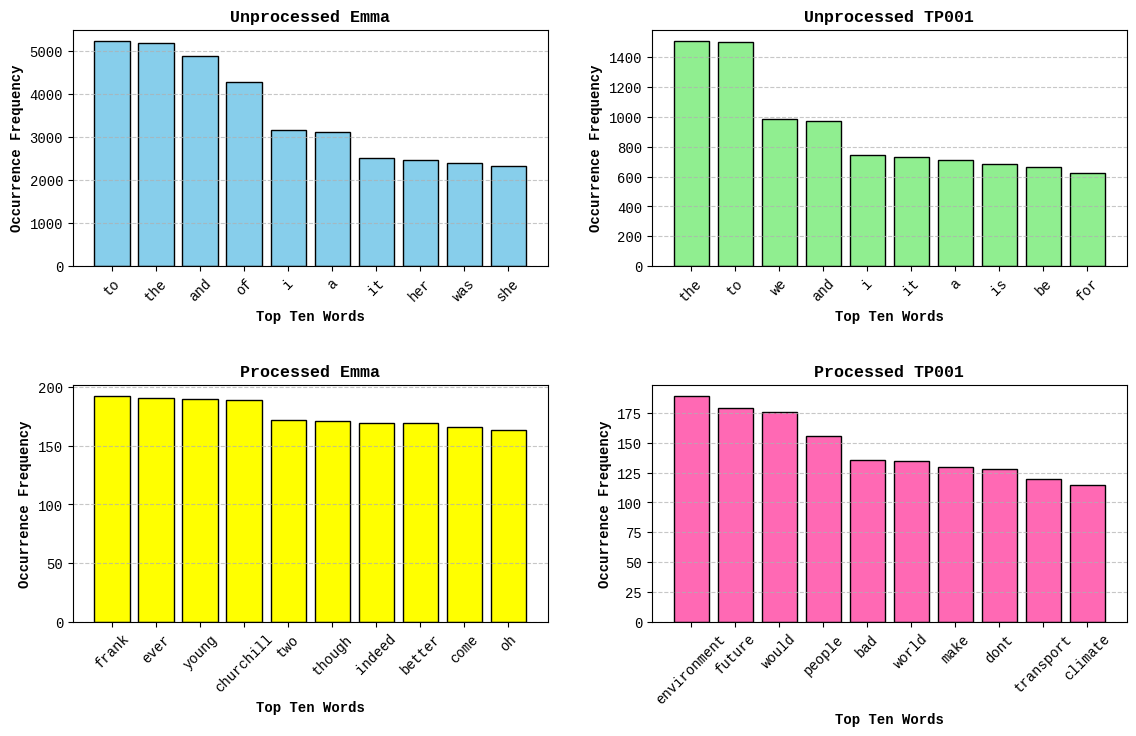


Removed words that occur more than 193 times.


In [51]:
# Plotting the graphs for both original and preprocessed texts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
bold_font = FontProperties(family='Liberation Mono', weight='bold', size=12)
small_bold_font = FontProperties(family='Liberation Mono', weight='bold', size=10)
label_font = FontProperties(family='Liberation Mono', size=10)

# Original Emma
axes[0, 0].bar(emma_top_ten_words, emma_frequencies, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Unprocessed Emma', fontproperties=bold_font)
axes[0, 0].set_xlabel('Top Ten Words', fontproperties=small_bold_font)
axes[0, 0].set_ylabel('Occurrence Frequency', fontproperties=small_bold_font)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[0, 0].get_xticklabels() + axes[0, 0].get_yticklabels():
    label.set_fontproperties(label_font)

# Original TP001
axes[0, 1].bar(tp001_top_ten_words, tp001_frequencies, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Unprocessed TP001', fontproperties=bold_font)
axes[0, 1].set_xlabel('Top Ten Words', fontproperties=small_bold_font)
axes[0, 1].set_ylabel('Occurrence Frequency', fontproperties=small_bold_font)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=10)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[0, 1].get_xticklabels() + axes[0, 1].get_yticklabels():
    label.set_fontproperties(label_font)

# Preprocessed Emma
axes[1, 0].bar(preprocessed_emma_top_ten, preprocessed_emma_freq, color='yellow', edgecolor='black')
axes[1, 0].set_title('Processed Emma', fontproperties=bold_font)
axes[1, 0].set_xlabel('Top Ten Words', fontproperties=small_bold_font)
axes[1, 0].set_ylabel('Occurrence Frequency', fontproperties=small_bold_font)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[1, 0].get_xticklabels() + axes[1, 0].get_yticklabels():
    label.set_fontproperties(label_font)

# Preprocessed TP001
axes[1, 1].bar(preprocessed_tp001_top_ten, preprocessed_tp001_freq, color='hotpink', edgecolor='black')
axes[1, 1].set_title('Processed TP001', fontproperties=bold_font)
axes[1, 1].set_xlabel('Top Ten Words', fontproperties=small_bold_font)
axes[1, 1].set_ylabel('Occurrence Frequency', fontproperties=small_bold_font)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
for label in axes[1, 1].get_xticklabels() + axes[1, 1].get_yticklabels():
    label.set_fontproperties(label_font)

# Show the plots
plt.tight_layout(pad=3)
plt.show()
print(f"\nRemoved words that occur more than {random_frequency} times.")

## **Comparing Lexical Diversity in Processed and Unprocessed Versions of "Emma" by Jane Austen.**

The results of the analysis below show the overall lexical diversity of Jane Austen's "Emma" in both its processed and unprocessed forms as the batch size (number of sentences per batch) increases.

**Processed Overall Lexical Diversity (Blue Line):** As the batch size increases, we observe a gradual decrease in lexical diversity. This indicates that when analyzing larger portions of the text together, the processed version becomes less lexically diverse.

**Unprocessed Overall Lexical Diversity (Red Line):** This line represents the lexical diversity of the original, unprocessed text. Similarly, as the batch size increases, we also see a decrease in lexical diversity. However, the unprocessed text tends to have a slightly higher lexical diversity compared to the processed version for larger batch sizes.

In [42]:
increment = 100  # n sentences per increment
batch_sizes = list(range(20, emma_num_sentences, increment))  # Incrementally increase batch size

overall_lex_div_unprocessed = []
overall_lex_div_processed = []

# Split the text into sentences
sentences = sent_tokenize(emma_text)

# Calculate lexical diversities
for batch_size in batch_sizes:
    # Concatenate all sentences up to the current batch size
    concatenated_unprocessed = ' '.join(sentences[:batch_size])
    concatenated_processed = preprocess_text(concatenated_unprocessed, stop_words, random_frequency)[0]

    # Calculate overall lexical diversity for the concatenated text
    overall_lex_div_unprocessed.append(text_metrics(concatenated_unprocessed)[1])
    overall_lex_div_processed.append(text_metrics(concatenated_processed)[1])

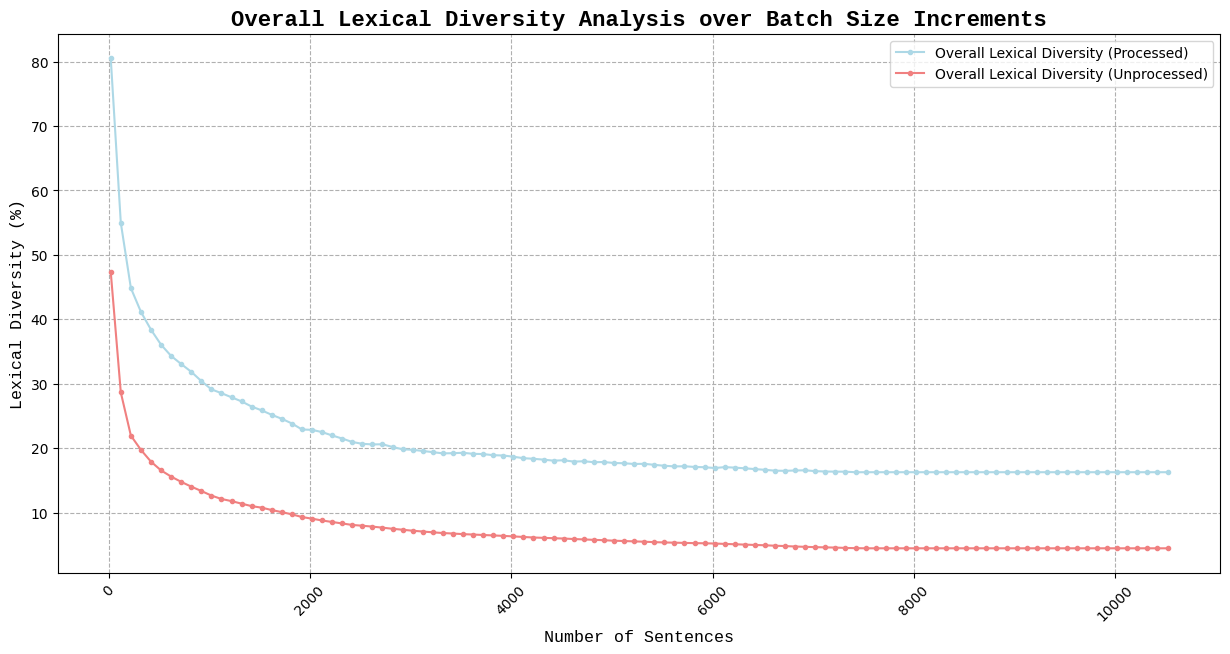


--------- Text Metrics for Emma (Unprocessed) ---------
Total Words: 161983
Total Sentences: 10567
Overall Lexical Diversity: 4.48%
Average Lexical Diversity of Sentences: 94.43%
Top Ten Most Frequent Words: to, the, and, of, i, a, it, her, was, she
Highest Frequency Word: 'to' (Frequency: 5239)

--------- Text Metrics for Emma (Processed) ---------
Total Words: 56909
Total Sentences: 1
Overall Lexical Diversity: 16.32%
Average Lexical Diversity of Sentences: 16.32%
Top Ten Most Frequent Words: frank, ever, young, churchill, two, though, indeed, better, come, oh
Highest Frequency Word: 'frank' (Frequency: 192)



In [52]:
# Prepare batch size labels with sentence count
batch_size_labels = [batch_size for batch_size in batch_sizes]

# Plotting the graph with rotated x-axis labels
plt.figure(figsize=(15, 7))
plt.plot(batch_size_labels, [ld * 100 for ld in overall_lex_div_processed], marker='.', linestyle='-', color='lightblue', label='Overall Lexical Diversity (Processed)')
plt.plot(batch_size_labels, [ld * 100 for ld in overall_lex_div_unprocessed], marker='.', linestyle='-', color='lightcoral', label='Overall Lexical Diversity (Unprocessed)')
plt.title('Overall Lexical Diversity Analysis over Batch Size Increments', fontsize=16, fontweight='bold', fontfamily='Liberation Mono')
plt.xlabel('Number of Sentences', fontsize=12, fontfamily='Liberation Mono')
plt.ylabel('Lexical Diversity (%)', fontsize=12, fontfamily='Liberation Mono')
plt.legend()
plt.tick_params(axis='x', rotation=45, labelsize=10)
plt.grid(linestyle='--')
plt.show()

print("\n" + format_metrics("Emma (Unprocessed)", emma_metrics) + "\n")
print(format_metrics("Emma (Processed)", preprocessed_emma_metrics) + "\n")